In [ ]:
print("hello")

hello


In [ ]:
# import system libs
import os
import time
import random
import pathlib
import itertools
from glob import glob
from tqdm import tqdm_notebook, tnrange

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.color import rgb2gray
from skimage.morphology import label
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow, concatenate_images

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("harshwardhanbhangale/lits-dataset-256x256-imgs")

print("Path to dataset files:", path)

100%|██████████| 813M/813M [00:41<00:00, 20.7MB/s]


Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/harshwardhanbhangale/lits-dataset-256x256-imgs/versions/2


In [ ]:
data_dir = "/root/.cache/kagglehub/datasets/harshwardhanbhangale/lits-dataset-256x256-imgs/versions/2"

In [ ]:
image_paths = sorted(glob(os.path.join(data_dir, 'train_frames/train_frames', '*')))
mask_paths = sorted(glob(os.path.join(data_dir, 'train_masks/train_masks', '*')))

In [ ]:
print(f"Found {len(image_paths)} images in train_frames")
print(f"Found {len(mask_paths)} masks in train_masks")

Found 49842 images in train_frames
Found 49842 masks in train_masks


Pixel values:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Fully black masks: 34097
Masks with drawings: 15745


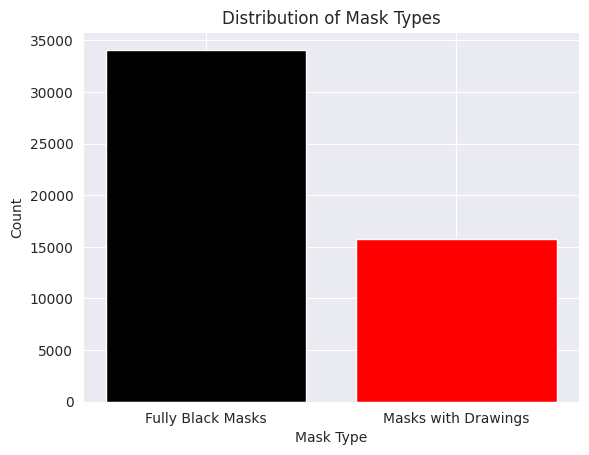

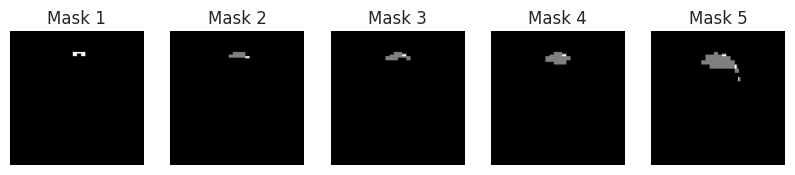

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob

def print_pixel_values(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read in grayscale
    print("Pixel values:")
    print(image)

def count_mask_types(mask_paths):
    black_count = 0
    drawn_count = 0
    drawn_masks = []

    for mask_path in mask_paths:
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if np.all(mask == 0):  # Fully black mask
            black_count += 1
        else:  # Mask contains something
            drawn_count += 1
            drawn_masks.append(mask_path)

    return black_count, drawn_count, drawn_masks

def plot_mask_distribution(black_count, drawn_count):
    categories = ['Fully Black Masks', 'Masks with Drawings']
    counts = [black_count, drawn_count]

    plt.bar(categories, counts, color=['black', 'red'])
    plt.xlabel("Mask Type")
    plt.ylabel("Count")
    plt.title("Distribution of Mask Types")
    plt.show()

def plot_sample_drawn_masks(drawn_masks, num_samples=5):
    plt.figure(figsize=(10, 5))

    for i, mask_path in enumerate(drawn_masks[:num_samples]):
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(mask, cmap='gray')
        plt.axis('off')
        plt.title(f"Mask {i+1}")

    plt.show()

# Example Usage
data_dir = "/root/.cache/kagglehub/datasets/harshwardhanbhangale/lits-dataset-256x256-imgs/versions/2"
image_paths = sorted(glob(os.path.join(data_dir, 'train_frames/train_frames', '*')))
mask_paths = sorted(glob(os.path.join(data_dir, 'train_masks/train_masks', '*')))

# Print pixel values of the first grayscale image
print_pixel_values(image_paths[0])

# Count fully black vs non-black masks
black_count, drawn_count, drawn_masks = count_mask_types(mask_paths)
print(f"Fully black masks: {black_count}")
print(f"Masks with drawings: {drawn_count}")

# Plot the distribution
plot_mask_distribution(black_count, drawn_count)

# Plot sample drawn masks
plot_sample_drawn_masks(drawn_masks)


In [ ]:
print("🖼️ First 5 images:", image_paths[:5])
print("🎭 First 5 masks:", mask_paths[:5])

🖼️ First 5 images: ['/root/.cache/kagglehub/datasets/harshwardhanbhangale/lits-dataset-256x256-imgs/versions/2/train_frames/train_frames/volume-0_slice_0.jpg', '/root/.cache/kagglehub/datasets/harshwardhanbhangale/lits-dataset-256x256-imgs/versions/2/train_frames/train_frames/volume-0_slice_10.jpg', '/root/.cache/kagglehub/datasets/harshwardhanbhangale/lits-dataset-256x256-imgs/versions/2/train_frames/train_frames/volume-0_slice_11.jpg', '/root/.cache/kagglehub/datasets/harshwardhanbhangale/lits-dataset-256x256-imgs/versions/2/train_frames/train_frames/volume-0_slice_12.jpg', '/root/.cache/kagglehub/datasets/harshwardhanbhangale/lits-dataset-256x256-imgs/versions/2/train_frames/train_frames/volume-0_slice_13.jpg']
🎭 First 5 masks: ['/root/.cache/kagglehub/datasets/harshwardhanbhangale/lits-dataset-256x256-imgs/versions/2/train_masks/train_masks/volume-0_slice_0.jpg', '/root/.cache/kagglehub/datasets/harshwardhanbhangale/lits-dataset-256x256-imgs/versions/2/train_masks/train_masks/volum

In [ ]:
# Extract file names without extensions
image_ids = {os.path.basename(p).split('.')[0] for p in image_paths}
mask_ids = {os.path.basename(p).split('.')[0] for p in mask_paths}

# Find common pairs
common_ids = list(image_ids & mask_ids)

print(f"🔍 Found {len(common_ids)} matching image-mask pairs")
print("📝 Sample matched IDs:", common_ids[:5])


🔍 Found 49842 matching image-mask pairs
📝 Sample matched IDs: ['volume-18_slice_631', 'volume-104_slice_667', 'volume-9_slice_290', 'volume-108_slice_774', 'volume-90_slice_164']


🎯 Selected IDs: ['volume-54_slice_78', 'volume-96_slice_362', 'volume-129_slice_220', 'volume-11_slice_429', 'volume-108_slice_575']


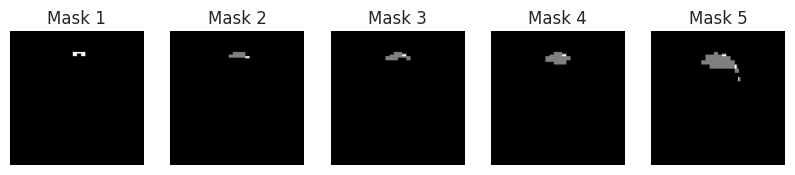

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
from glob import glob

def print_pixel_values(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read in grayscale
    print("Pixel values:")
    print(image)

def get_drawn_masks(mask_paths):
    drawn_masks = []

    for mask_path in mask_paths:
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if not np.all(mask == 0):  # Mask contains something
            drawn_masks.append(mask_path)

    return drawn_masks

def plot_mask_distribution(black_count, drawn_count):
    categories = ['Fully Black Masks', 'Masks with Drawings']
    counts = [black_count, drawn_count]

    plt.bar(categories, counts, color=['black', 'red'])
    plt.xlabel("Mask Type")
    plt.ylabel("Count")
    plt.title("Distribution of Mask Types")
    plt.show()

def plot_sample_drawn_masks(drawn_masks, num_samples=5):
    plt.figure(figsize=(10, 5))

    for i, mask_path in enumerate(drawn_masks[:num_samples]):
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(mask, cmap='gray')
        plt.axis('off')
        plt.title(f"Mask {i+1}")

    plt.show()

# Example Usage
data_dir = "/root/.cache/kagglehub/datasets/harshwardhanbhangale/lits-dataset-256x256-imgs/versions/2"
image_paths = sorted(glob(os.path.join(data_dir, 'train_frames/train_frames', '*')))
mask_paths = sorted(glob(os.path.join(data_dir, 'train_masks/train_masks', '*')))

# Get only drawn masks
drawn_masks = get_drawn_masks(mask_paths)

# Select random samples from drawn masks
sample_size = 15000
if len(drawn_masks) < sample_size:
    raise ValueError(f"❌ Not enough masks with drawings! Found {len(drawn_masks)}")

selected_ids = [os.path.splitext(os.path.basename(path))[0] for path in random.sample(drawn_masks, sample_size)]

# Debug: Print first 5 selected IDs
print("🎯 Selected IDs:", selected_ids[:5])

# Plot sample drawn masks
plot_sample_drawn_masks(drawn_masks)


In [ ]:
len(selected_ids)

15000

In [ ]:
import pandas as pd

# Create lists of image and mask paths
images_selected = [os.path.join(data_dir, 'train_frames/train_frames', f"{img_id}.jpg") for img_id in selected_ids]
masks_selected = [os.path.join(data_dir, 'train_masks/train_masks', f"{img_id}.jpg") for img_id in selected_ids]  # Change .jpg if needed

df = pd.DataFrame({'images_paths': images_selected, 'masks_paths': masks_selected})
pd.set_option('display.max_colwidth', None)  # Show full paths
print(df.head())



                                                                                                                                   images_paths  \
0    /root/.cache/kagglehub/datasets/harshwardhanbhangale/lits-dataset-256x256-imgs/versions/2/train_frames/train_frames/volume-54_slice_78.jpg   
1   /root/.cache/kagglehub/datasets/harshwardhanbhangale/lits-dataset-256x256-imgs/versions/2/train_frames/train_frames/volume-96_slice_362.jpg   
2  /root/.cache/kagglehub/datasets/harshwardhanbhangale/lits-dataset-256x256-imgs/versions/2/train_frames/train_frames/volume-129_slice_220.jpg   
3   /root/.cache/kagglehub/datasets/harshwardhanbhangale/lits-dataset-256x256-imgs/versions/2/train_frames/train_frames/volume-11_slice_429.jpg   
4  /root/.cache/kagglehub/datasets/harshwardhanbhangale/lits-dataset-256x256-imgs/versions/2/train_frames/train_frames/volume-108_slice_575.jpg   

                                                                                                                     

In [ ]:
from sklearn.model_selection import train_test_split

# Split data
train_df, temp_df = train_test_split(df, train_size=0.8, random_state=42)
valid_df, test_df = train_test_split(temp_df, train_size=0.5, random_state=42)

# Debug: Print sizes
print(f"📂 Train: {len(train_df)} images")
print(f"📂 Validation: {len(valid_df)} images")
print(f"📂 Test: {len(test_df)} images")


📂 Train: 12000 images
📂 Validation: 1500 images
📂 Test: 1500 images


In [ ]:
import cv2

# Pick a sample mask
sample_mask_path = masks_selected[0]  # First mask

# Print the path to check if it's valid
print(f"Checking mask at path: {sample_mask_path}")

# Load mask
mask = cv2.imread(sample_mask_path, cv2.IMREAD_UNCHANGED)

# Check if mask is loaded
if mask is None:
    print(f"❌ Error: Could not read image at {sample_mask_path}")
    # Add more error handling or investigation here
else:
    # Check format
    if len(mask.shape) == 2:
        print(f"🎭 Mask at {sample_mask_path} is Grayscale")
    else:
        print(f"❌ Mask at {sample_mask_path} is NOT Grayscale")

Checking mask at path: /root/.cache/kagglehub/datasets/harshwardhanbhangale/lits-dataset-256x256-imgs/versions/2/train_masks/train_masks/volume-54_slice_78.jpg
🎭 Mask at /root/.cache/kagglehub/datasets/harshwardhanbhangale/lits-dataset-256x256-imgs/versions/2/train_masks/train_masks/volume-54_slice_78.jpg is Grayscale


In [ ]:
def create_gens(df, aug_dict):
    img_size = (256, 256)
    batch_size = 40


    img_gen = ImageDataGenerator(**aug_dict)
    msk_gen = ImageDataGenerator(**aug_dict)

    # Create general generator
    image_gen = img_gen.flow_from_dataframe(df, x_col='images_paths', class_mode=None, color_mode='rgb', target_size=img_size,
                                            batch_size=batch_size, save_to_dir=None, save_prefix='image', seed=1)

    mask_gen = msk_gen.flow_from_dataframe(df, x_col='masks_paths', class_mode=None, color_mode='grayscale', target_size=img_size,
                                            batch_size=batch_size, save_to_dir=None, save_prefix= 'mask', seed=1)

    gen = zip(image_gen, mask_gen)

    for (img, msk) in gen:
        img = img / 255
        msk = msk
        msk[msk > 0.5] = 1
        msk[msk <= 0.5] = 0

        yield (img, msk)

In [ ]:
def unet(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # First DownConvolution / Encoder Leg will begin, so start with Conv2D
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(inputs)
    bn1 = Activation("relu")(conv1)
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation("relu")(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(pool1)
    bn2 = Activation("relu")(conv2)
    conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation("relu")(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(pool2)
    bn3 = Activation("relu")(conv3)
    conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation("relu")(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(pool3)
    bn4 = Activation("relu")(conv4)
    conv4 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation("relu")(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(pool4)
    bn5 = Activation("relu")(conv5)
    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation("relu")(bn5)

    """ Now UpConvolution / Decoder Leg will begin, so start with Conv2DTranspose
    The gray arrows (in the above image) indicate the skip connections that concatenate the encoder feature map with the decoder, which helps the backward flow of gradients for improved training. """
    """ After every concatenation we again apply two consecutive regular convolutions so that the model can learn to assemble a more precise output """

    up6 = concatenate([Conv2DTranspose(512, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn5), conv4], axis=3)
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(up6)
    bn6 = Activation("relu")(conv6)
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation("relu")(bn6)

    up7 = concatenate([Conv2DTranspose(256, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn6), conv3], axis=3)
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(up7)
    bn7 = Activation("relu")(conv7)
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation("relu")(bn7)

    up8 = concatenate([Conv2DTranspose(128, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn7), conv2], axis=3)
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(up8)
    bn8 = Activation("relu")(conv8)
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation("relu")(bn8)

    up9 = concatenate([Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn8), conv1], axis=3)
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(up9)
    bn9 = Activation("relu")(conv9)
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation("relu")(bn9)

    conv10 = Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid")(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
from glob import glob
import tensorflow.keras.backend as K

In [ ]:
def dice_coef(y_true, y_pred, smooth=100):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)

    intersection = K.sum(y_true_flatten * y_pred_flatten)
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)
    return (2 * intersection + smooth) / (union + smooth)

def dice_loss(y_true, y_pred, smooth=100):
    return -dice_coef(y_true, y_pred, smooth)

def iou_coef(y_true, y_pred, smooth=100):
    intersection = K.sum(y_true * y_pred)
    sum_union = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum_union - intersection + smooth)
    return iou

def dice_precision(y_true, y_pred, smooth=100):
    intersection = K.sum(y_true * y_pred)
    return (intersection + smooth) / (K.sum(y_pred) + smooth)

def dice_sensitivity(y_true, y_pred, smooth=100):
    intersection = K.sum(y_true * y_pred)
    return (intersection + smooth) / (K.sum(y_true) + smooth)

def jaccard_loss(y_true, y_pred, smooth=100):
    return 1 - iou_coef(y_true, y_pred, smooth)

def hd95_loss(y_true, y_pred):
    from medpy.metric.binary import hd95
    y_true_np = K.eval(y_true)
    y_pred_np = K.eval(y_pred)
    return hd95(y_true_np, y_pred_np)

In [ ]:
print(f"📂 Train: {len(train_df)} images")
print(f"📂 Validation: {len(valid_df)} images")
print(f"📂 Test: {len(test_df)} images")

# Print first few paths to verify
print("🔍 Sample train images:", train_df['images_paths'].tolist()[:5])
print("🔍 Sample train masks:", train_df['masks_paths'].tolist()[:5])


📂 Train: 12000 images
📂 Validation: 1500 images
📂 Test: 1500 images
🔍 Sample train images: ['/root/.cache/kagglehub/datasets/harshwardhanbhangale/lits-dataset-256x256-imgs/versions/2/train_frames/train_frames/volume-128_slice_545.jpg', '/root/.cache/kagglehub/datasets/harshwardhanbhangale/lits-dataset-256x256-imgs/versions/2/train_frames/train_frames/volume-100_slice_439.jpg', '/root/.cache/kagglehub/datasets/harshwardhanbhangale/lits-dataset-256x256-imgs/versions/2/train_frames/train_frames/volume-29_slice_74.jpg', '/root/.cache/kagglehub/datasets/harshwardhanbhangale/lits-dataset-256x256-imgs/versions/2/train_frames/train_frames/volume-93_slice_488.jpg', '/root/.cache/kagglehub/datasets/harshwardhanbhangale/lits-dataset-256x256-imgs/versions/2/train_frames/train_frames/volume-101_slice_408.jpg']
🔍 Sample train masks: ['/root/.cache/kagglehub/datasets/harshwardhanbhangale/lits-dataset-256x256-imgs/versions/2/train_masks/train_masks/volume-128_slice_545.jpg', '/root/.cache/kagglehub/da

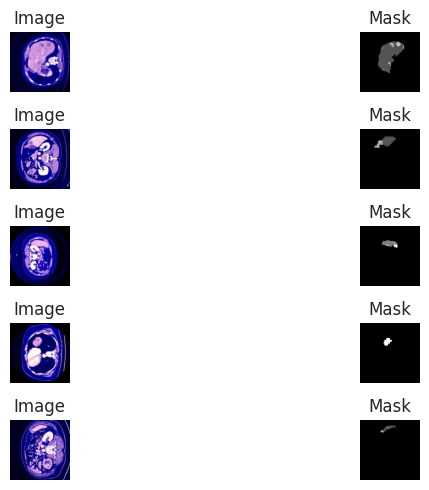

In [ ]:
# Function to visualize images and masks
import matplotlib.pyplot as plt
import cv2

def show_images(image_paths, mask_paths, num_samples=5):
    plt.figure(figsize=(10, 5))
    for i in range(num_samples):
        img = cv2.imread(image_paths[i])  # Read image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB

        mask = cv2.imread(mask_paths[i], cv2.IMREAD_GRAYSCALE)  # Read mask

        plt.subplot(num_samples, 2, 2*i+1)
        plt.imshow(img)
        plt.title("Image")
        plt.axis("off")

        plt.subplot(num_samples, 2, 2*i+2)
        plt.imshow(mask, cmap="gray")
        plt.title("Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Show some train images and masks
show_images(train_df['images_paths'].tolist(), train_df['masks_paths'].tolist(), num_samples=5)


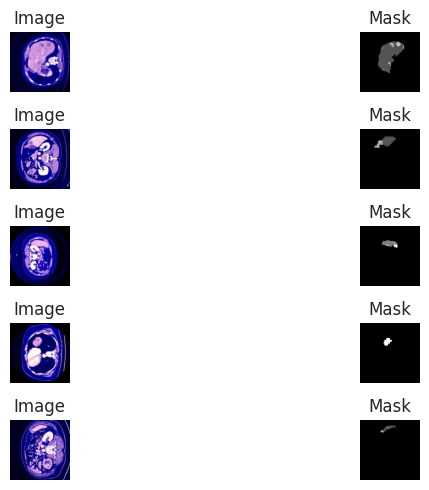

In [ ]:
tr_aug_dict = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')


train_gen = create_gens(train_df, aug_dict=tr_aug_dict)
valid_gen = create_gens(valid_df, aug_dict={})
test_gen = create_gens(test_df, aug_dict={})

show_images(list(train_df['images_paths']), list(train_df['masks_paths']))

In [ ]:
model = unet()
model.compile(Adamax(learning_rate= 0.001), loss= dice_loss, metrics=['accuracy', iou_coef, dice_coef, dice_precision, dice_sensitivity, jaccard_loss])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ activation_4[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_5[0][0]  

 Total params: 31,043,521 (118.42 MB)

 Trainable params: 31,037,633 (118.40 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [ ]:
def plot_training(hist):
    '''
    This function takes the training history and plots accuracy and losses,
    highlighting the best epoch for each metric.
    '''

    # Extract training history
    tr_acc = hist.history['accuracy']
    tr_iou = hist.history['iou_coef']
    tr_dice = hist.history['dice_coef']
    tr_loss = hist.history['loss']
    tr_prec = hist.history['dice_precision']
    tr_sens = hist.history['dice_sensitivity']
    tr_jaccard = hist.history['jaccard_loss']

    val_acc = hist.history['val_accuracy']
    val_iou = hist.history['val_iou_coef']
    val_dice = hist.history['val_dice_coef']
    val_loss = hist.history['val_loss']
    val_prec = hist.history['val_dice_precision']
    val_sens = hist.history['val_dice_sensitivity']
    val_jaccard = hist.history['val_jaccard_loss']

    # Find best epochs
    index_acc = np.argmax(val_acc)
    index_iou = np.argmax(val_iou)
    index_dice = np.argmax(val_dice)
    index_prec = np.argmax(val_prec)
    index_sens = np.argmax(val_sens)
    index_jaccard = np.argmin(val_jaccard)  # Jaccard is a loss (lower is better)
    index_loss = np.argmin(val_loss)

    # Best values
    acc_highest = val_acc[index_acc]
    iou_highest = val_iou[index_iou]
    dice_highest = val_dice[index_dice]
    prec_highest = val_prec[index_prec]
    sens_highest = val_sens[index_sens]
    jaccard_lowest = val_jaccard[index_jaccard]
    val_lowest = val_loss[index_loss]

    Epochs = list(range(1, len(tr_acc) + 1))

    # Plot training history
    plt.figure(figsize=(20, 25))
    plt.style.use('fivethirtyeight')

    # Training Accuracy
    plt.subplot(3, 2, 1)
    plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
    plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=f'Best Epoch = {index_acc + 1}')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Training IoU
    plt.subplot(3, 2, 2)
    plt.plot(Epochs, tr_iou, 'r', label='Training IoU')
    plt.plot(Epochs, val_iou, 'g', label='Validation IoU')
    plt.scatter(index_iou + 1, iou_highest, s=150, c='blue', label=f'Best Epoch = {index_iou + 1}')
    plt.title('Training and Validation IoU Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()

    # Training Dice
    plt.subplot(3, 2, 3)
    plt.plot(Epochs, tr_dice, 'r', label='Training Dice')
    plt.plot(Epochs, val_dice, 'g', label='Validation Dice')
    plt.scatter(index_dice + 1, dice_highest, s=150, c='blue', label=f'Best Epoch = {index_dice + 1}')
    plt.title('Training and Validation Dice Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('Dice')
    plt.legend()

    # Training Dice Precision
    plt.subplot(3, 2, 4)
    plt.plot(Epochs, tr_prec, 'r', label='Training Precision')
    plt.plot(Epochs, val_prec, 'g', label='Validation Precision')
    plt.scatter(index_prec + 1, prec_highest, s=150, c='blue', label=f'Best Epoch = {index_prec + 1}')
    plt.title('Training and Validation Dice Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()

    # Training Dice Sensitivity
    plt.subplot(3, 2, 5)
    plt.plot(Epochs, tr_sens, 'r', label='Training Sensitivity')
    plt.plot(Epochs, val_sens, 'g', label='Validation Sensitivity')
    plt.scatter(index_sens + 1, sens_highest, s=150, c='blue', label=f'Best Epoch = {index_sens + 1}')
    plt.title('Training and Validation Dice Sensitivity')
    plt.xlabel('Epochs')
    plt.ylabel('Sensitivity')
    plt.legend()

    # Training Jaccard Loss
    plt.subplot(3, 2, 6)
    plt.plot(Epochs, tr_jaccard, 'r', label='Training Jaccard Loss')
    plt.plot(Epochs, val_jaccard, 'g', label='Validation Jaccard Loss')
    plt.scatter(index_jaccard + 1, jaccard_lowest, s=150, c='blue', label=f'Best Epoch = {index_jaccard + 1}')
    plt.title('Training and Validation Jaccard Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Jaccard Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
import matplotlib.pyplot as plt

def create_gens(df, aug_dict, preview=False, num_samples=5):
    img_size = (256, 256)
    batch_size = 40

    img_gen = ImageDataGenerator(**aug_dict)
    msk_gen = ImageDataGenerator(**aug_dict)

    image_gen = img_gen.flow_from_dataframe(df, x_col='images_paths', class_mode=None, color_mode='rgb',
                                            target_size=img_size, batch_size=batch_size, seed=1)

    mask_gen = msk_gen.flow_from_dataframe(df, x_col='masks_paths', class_mode=None, color_mode='grayscale',
                                           target_size=img_size, batch_size=batch_size, seed=1)

    gen = zip(image_gen, mask_gen)

    # 🔥 Preview Some Samples
    if preview:
        img_batch, mask_batch = next(gen)  # Get one batch

        plt.figure(figsize=(10, 5))

        for i in range(num_samples):
            plt.subplot(2, num_samples, i + 1)
            plt.imshow(img_batch[i])  # RGB Image
            plt.axis('off')
            plt.title(f"Image {i+1}")

            plt.subplot(2, num_samples, num_samples + i + 1)
            plt.imshow(mask_batch[i].squeeze(), cmap='gray')  # Grayscale Mask
            plt.axis('off')
            plt.title(f"Mask {i+1}")

        plt.show()

    for (img, msk) in gen:
        img = img / 255.0  # Normalize
        msk = (msk > 0.5).astype(int)  # Binarize

        yield (img, msk)


In [ ]:
aug_dict = {
    'rotation_range': 20,
    'width_shift_range': 0.1,
    'height_shift_range': 0.1,
    'shear_range': 0.1,
    'zoom_range': 0.2,
    'horizontal_flip': True,
    'fill_mode': 'nearest'
}

In [ ]:
create_gens(df, aug_dict, preview=True)


<generator object create_gens at 0x7e109d6e0040>

Found 15000 validated image filenames.
Found 15000 validated image filenames.


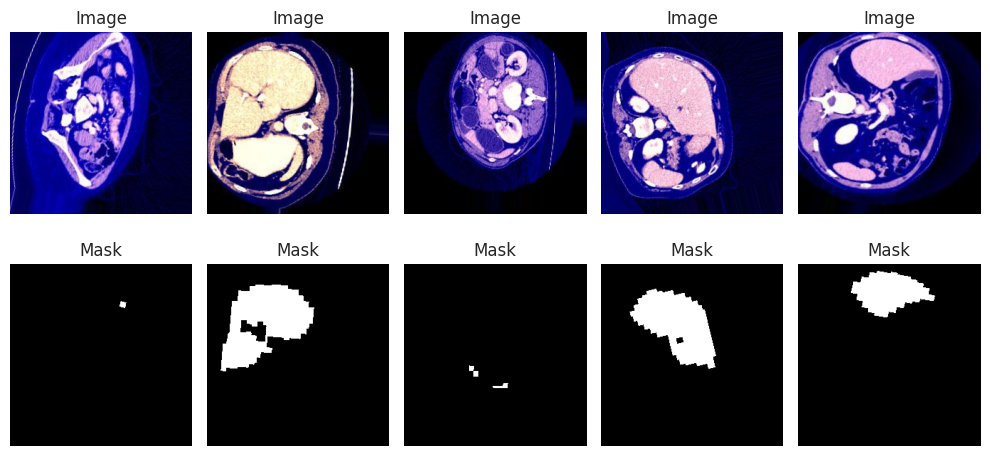

In [ ]:
import matplotlib.pyplot as plt

# Create the generator
gen = create_gens(df, aug_dict)

# Fetch a batch (images, masks) from the generator
images, masks = next(gen)  # Get one batch

# Display the first 5 images and their corresponding masks
num_samples = 5
plt.figure(figsize=(10, 5))

for i in range(num_samples):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(images[i])  # Show the image
    plt.axis('off')
    plt.title("Image")

    plt.subplot(2, num_samples, i + 1 + num_samples)
    plt.imshow(masks[i].squeeze(), cmap='gray')  # Show the mask
    plt.axis('off')
    plt.title("Mask")

plt.tight_layout()
plt.show()


In [ ]:
epochs = 20
print(epochs)
batch_size = 40
callbacks = [ModelCheckpoint('unet.keras', verbose=0, save_best_only=True)]

history = model.fit(train_gen,
                    steps_per_epoch=len(train_df) // batch_size,
                    epochs=epochs,
                    verbose=2,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(valid_df) // batch_size)

In [ ]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('final_model.keras')
print("✅ Model loaded successfully!")


TypeError: Could not locate function 'dice_loss'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'builtins', 'class_name': 'function', 'config': 'dice_loss', 'registered_name': 'function'}

In [ ]:
import os

# Print current directory
print("📂 Current Directory (pwd):", os.getcwd())

# Print contents of the current directory
print("📁 Files and Folders:")
for item in os.listdir():
    print(" -", item)


📂 Current Directory (pwd): /content
📁 Files and Folders:
 - .config
 - final_model.keras
 - sample_data
